###Importing Libraries

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=248db0037b1b8bda12a3bb5d627efb466f9d68bfb592ae376378f68c165eaf6d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, applications
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import pandas as pd


###Defining Hyperparameters

In [ ]:
# Define key parameters for the project
BATCH_SIZE = 16
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 30
LEARNING_RATE = 0.001

###Setting Random Seeds

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

###Downloading and Extracting the Dataset

In [ ]:
# Set up Kaggle API credentials to download the dataset
os.makedirs('/root/.kaggle', exist_ok=True)
os.system('cp kaggle.json /root/.kaggle/')
os.system('chmod 600 /root/.kaggle/kaggle.json')

# Download and extract the dataset
os.system('kaggle datasets download -d emmarex/plantdisease')
with zipfile.ZipFile('plantdisease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

###Loading and Printing the Dataset

Found 20638 files belonging to 15 classes.
Total Classes: 15
Class Names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


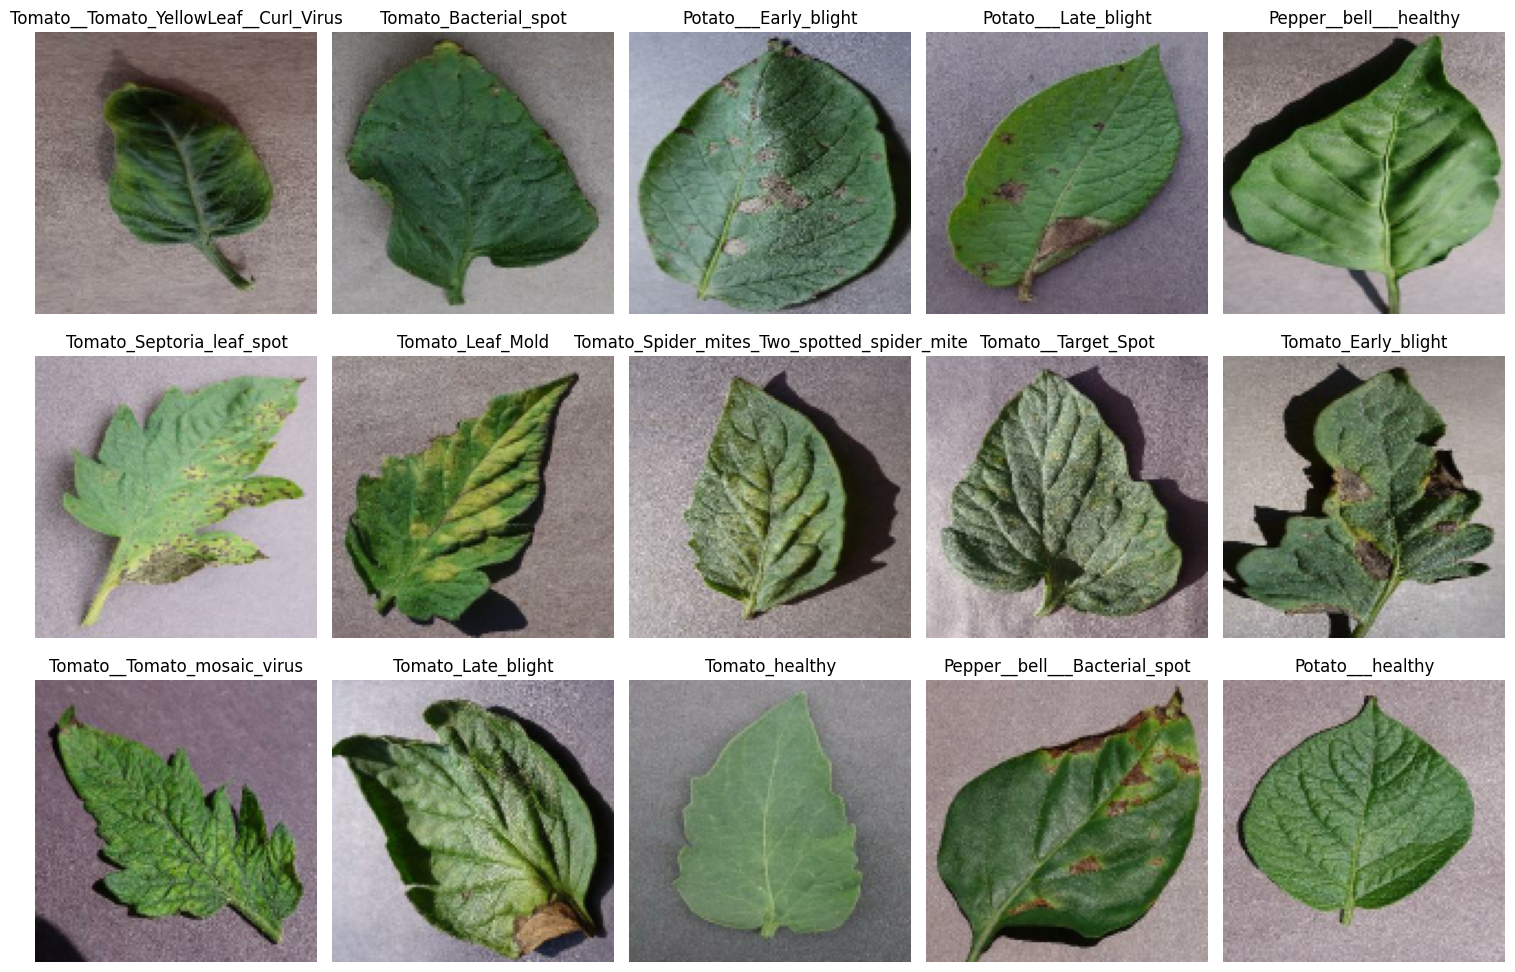

In [ ]:
# Load the dataset as a TensorFlow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names from the dataset
class_names = dataset.class_names
print(f"Total Classes: {len(class_names)}")
print("Class Names:", class_names)

# Display one image from each class
def display_one_image_per_class(dataset, class_names):
    class_images = {}
    plt.figure(figsize=(15, 10))

    # Iterate over the dataset
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            if class_name not in class_images:
                class_images[class_name] = img
            if len(class_images) == len(class_names):
                break
        if len(class_images) == len(class_names):
            break

    # Plot images
    for i, (class_name, img) in enumerate(class_images.items()):
        ax = plt.subplot(3, (len(class_names) + 2) // 3, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
display_one_image_per_class(dataset, class_names)

In [ ]:
# Print class names with numbering in 3 columns
for i, class_name in enumerate(class_names, 1):
    print(f"{i}. {class_name:20}", end="\n" if i % 3 == 0 else "")


1. Pepper__bell___Bacterial_spot2. Pepper__bell___healthy3. Potato___Early_blight
4. Potato___Late_blight5. Potato___healthy    6. Tomato_Bacterial_spot
7. Tomato_Early_blight 8. Tomato_Late_blight  9. Tomato_Leaf_Mold    
10. Tomato_Septoria_leaf_spot11. Tomato_Spider_mites_Two_spotted_spider_mite12. Tomato__Target_Spot 
13. Tomato__Tomato_YellowLeaf__Curl_Virus14. Tomato__Tomato_mosaic_virus15. Tomato_healthy      


###Splitting and Preprocessing the Dataset

In [ ]:
# Split dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds = dataset.take(train_size)
temp_ds = dataset.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

# Optimize datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###Data Augmentation

In [ ]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
])


###Building the Model

In [ ]:
# Use a lighter base model to reduce memory usage
base_model = applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),  # Reduced units for less memory usage
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Display model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

###Training the Model

In [ ]:
# Train the model with adjusted parameters
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.6224 - loss: 1.1917 - val_accuracy: 0.8421 - val_loss: 0.4744 - learning_rate: 0.0010
Epoch 2/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8070 - loss: 0.5573 - val_accuracy: 0.8556 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 3/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8353 - loss: 0.4805 - val_accuracy: 0.8726 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 4/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8459 - loss: 0.4463 - val_accuracy: 0.8779 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 5/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8474 - loss: 0.4300 - val_accuracy: 0.8813 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 6/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8610 - loss: 0.3874 - val_accuracy: 0.8847 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 7/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.871

###Saving the Model

In [ ]:
# Save the trained model to a specified directory
model_save_path = "/content/saved_model.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/saved_model.h5


###Plot Training History

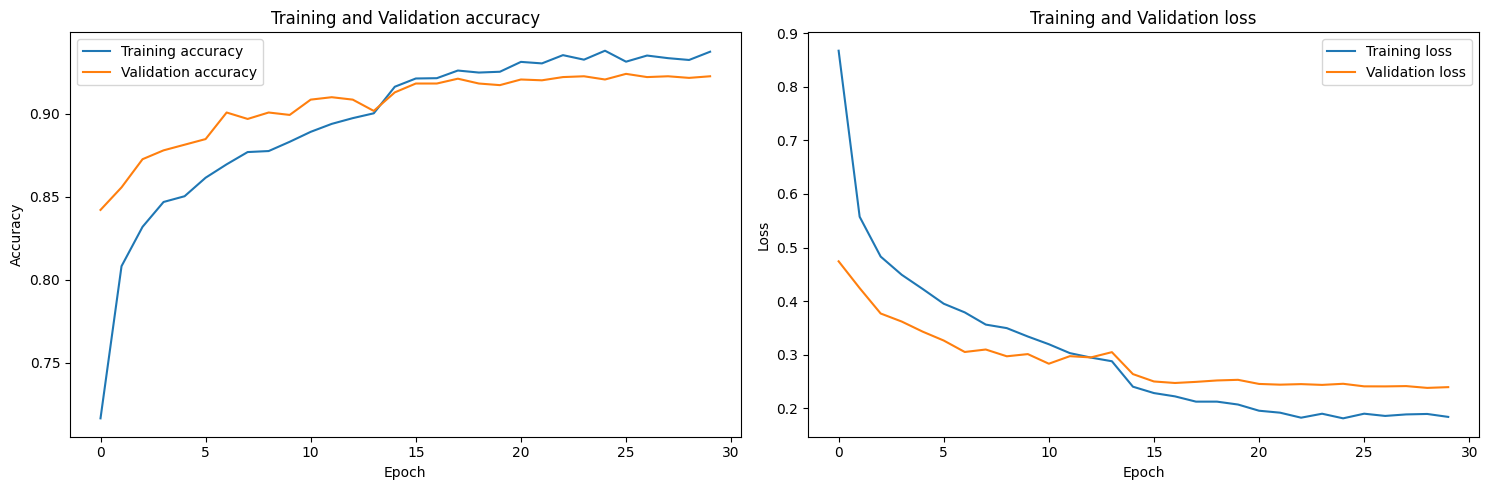

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))
metrics = ['accuracy', 'loss']

for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

###Evaluate on Test Set

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.2%}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9179 - loss: 0.2195

Test Accuracy: 92.05%


###Predict and Display Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


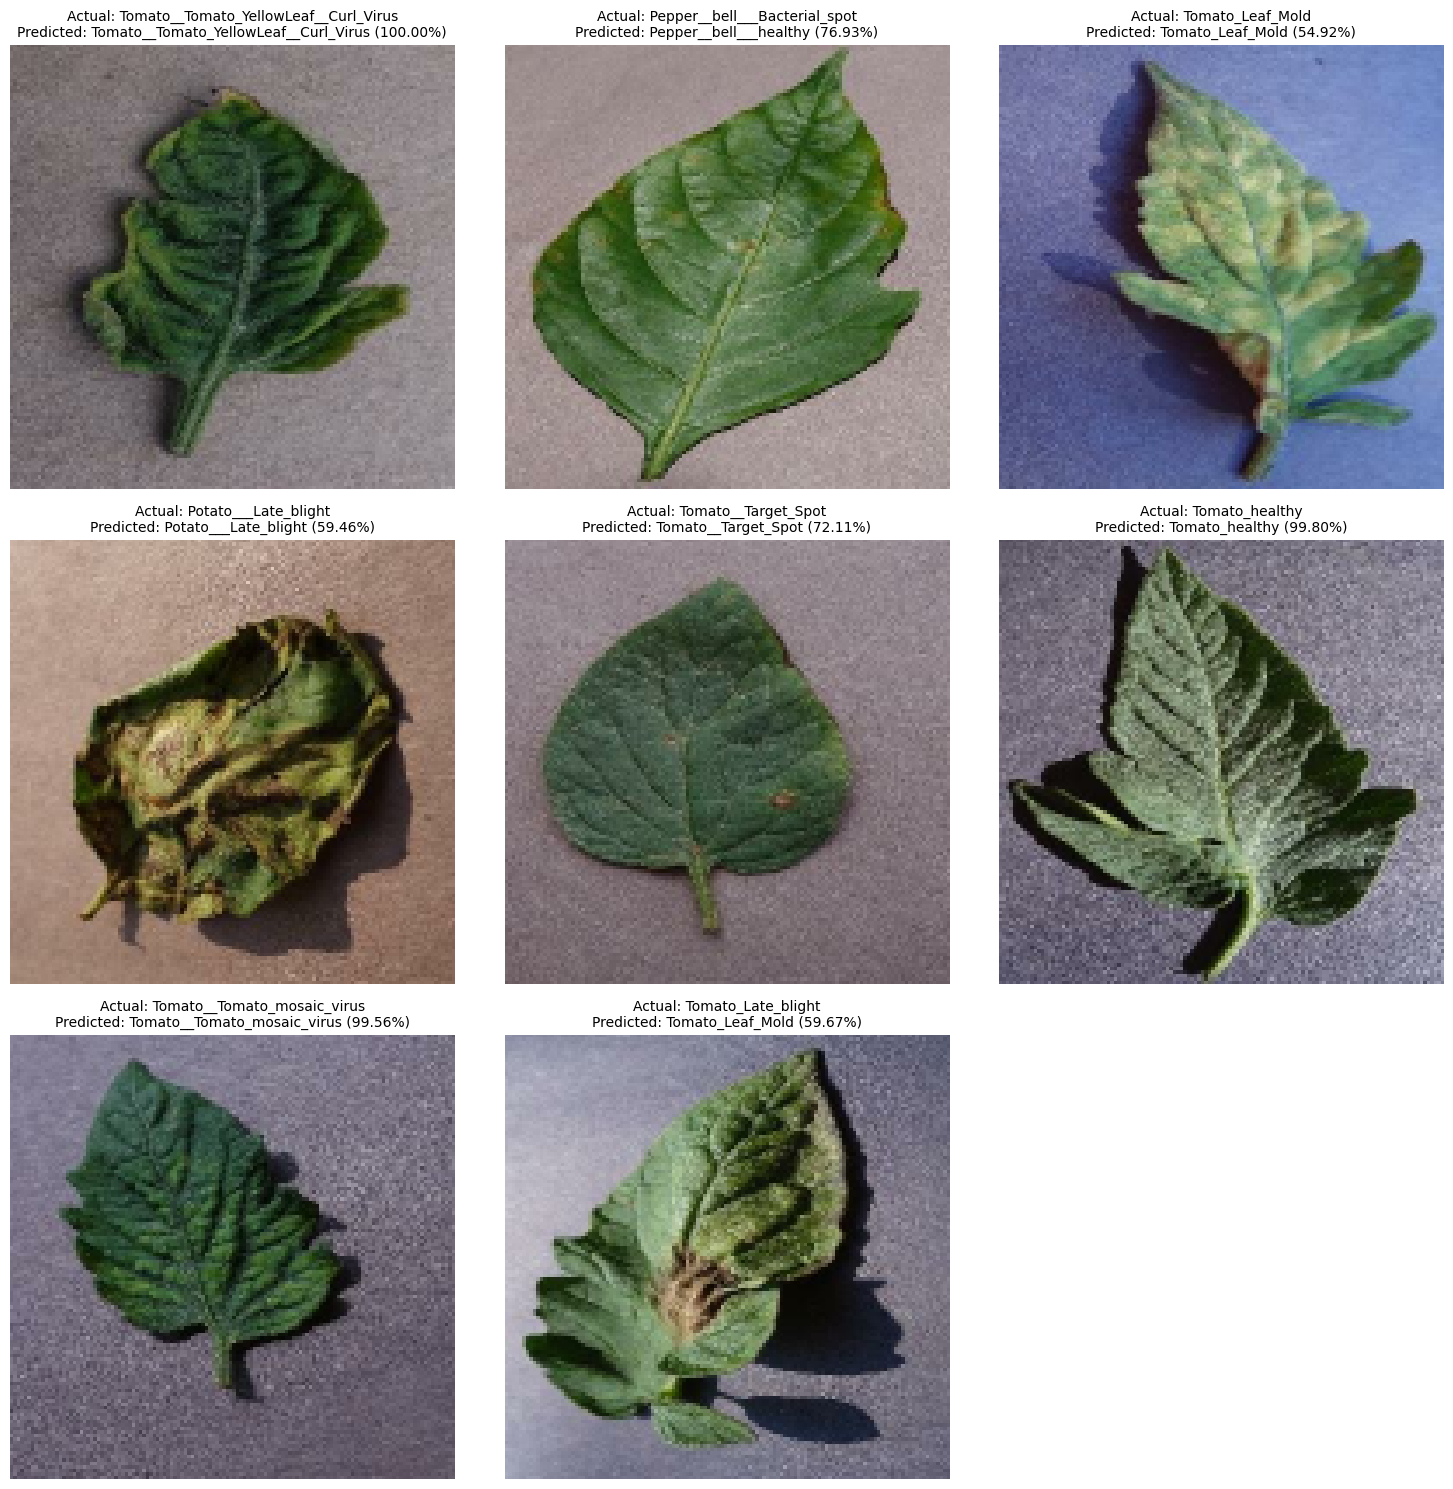

In [ ]:
# Predict and visualize a few images from the test dataset
def predict_and_visualize(model, test_dataset, class_names, num_images=8):
    """Visualize predictions for a given number of images from the test dataset."""
    plt.figure(figsize=(15, 15))

    for images, labels in test_dataset.take(1):
        for i in range(num_images):
            image = images[i].numpy().astype("uint8")
            label = labels[i].numpy()

            # Predict the class of the image
            prediction = model.predict(np.expand_dims(image, axis=0))
            predicted_class = np.argmax(prediction[0])
            confidence = prediction[0][predicted_class]

            # Display the image and predictions
            plt.subplot(3, 3, i+1)
            plt.imshow(image)
            plt.title(
                f"Actual: {class_names[label]}\n"
                f"Predicted: {class_names[predicted_class]} ({confidence:.2%})",
                fontsize=10,
            )
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Calling the function to visualize predictions
predict_and_visualize(model, test_ds, class_names, num_images=8)


###Generate Predictions for Confusion Matrix

In [ ]:
# Get predictions for confusion matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

###Plot Confusion Matrix

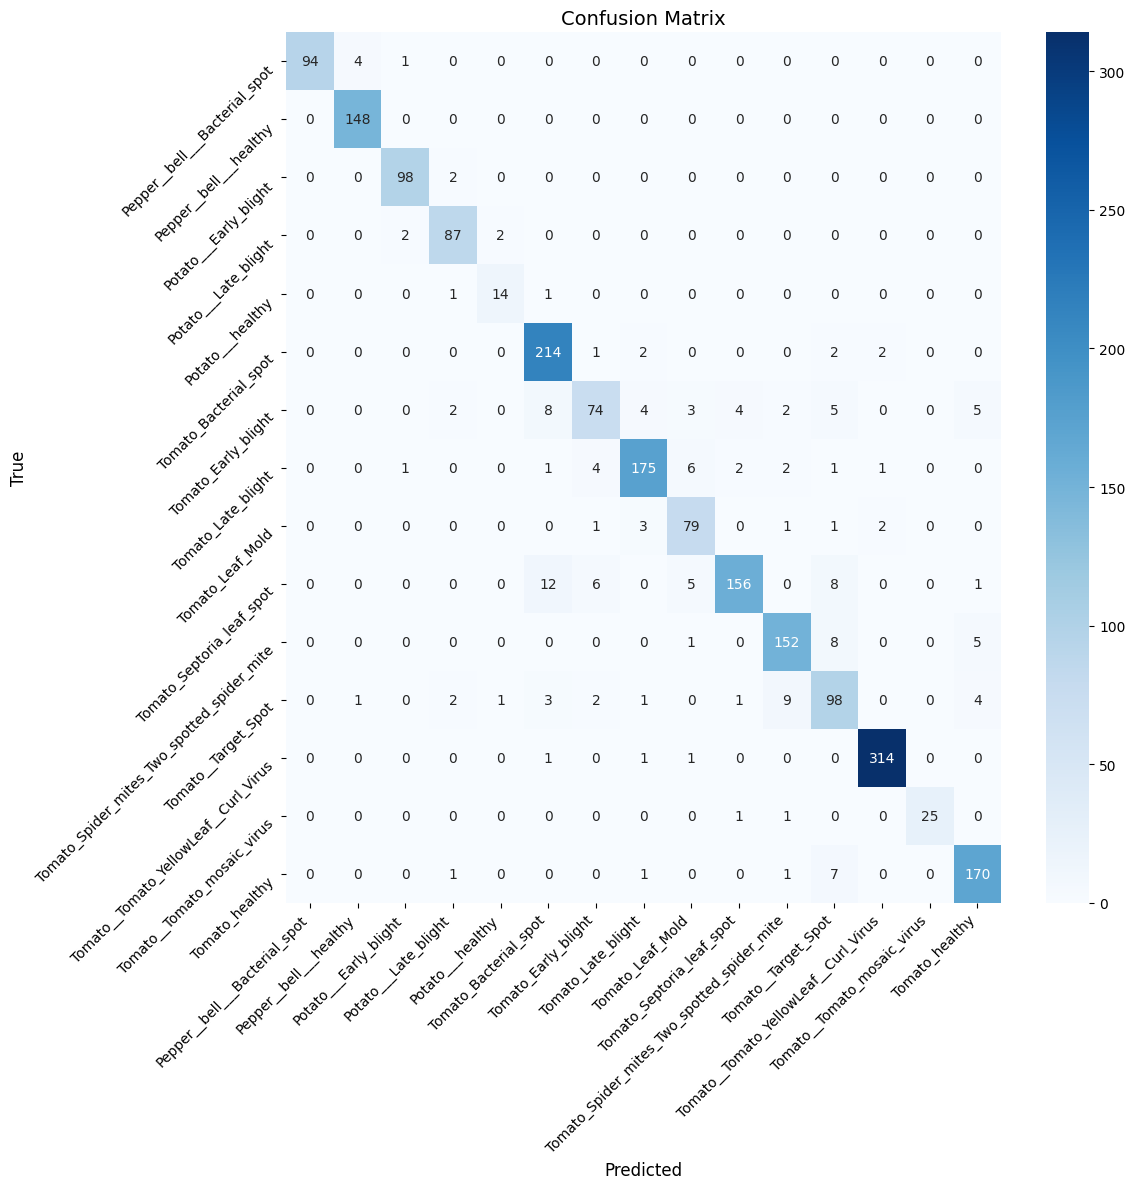

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=45, ha='right', va='top', fontsize=10)

plt.tight_layout()
plt.show()

###Print Classification Report

In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.95      0.97        99
                     Pepper__bell___healthy       0.97      1.00      0.98       148
                      Potato___Early_blight       0.96      0.98      0.97       100
                       Potato___Late_blight       0.92      0.96      0.94        91
                           Potato___healthy       0.82      0.88      0.85        16
                      Tomato_Bacterial_spot       0.89      0.97      0.93       221
                        Tomato_Early_blight       0.84      0.69      0.76       107
                         Tomato_Late_blight       0.94      0.91      0.92       193
                           Tomato_Leaf_Mold       0.83      0.91      0.87        87
                  Tomato_Septoria_leaf_spot       0.95      0.83      0.89       188
Tomato_Spider_mites_Two_spotted_spider_m

###Define Function for LIME Explanations


Analyzing Image 11
Actual Class: Tomato__Tomato_YellowLeaf__Curl_Virus


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

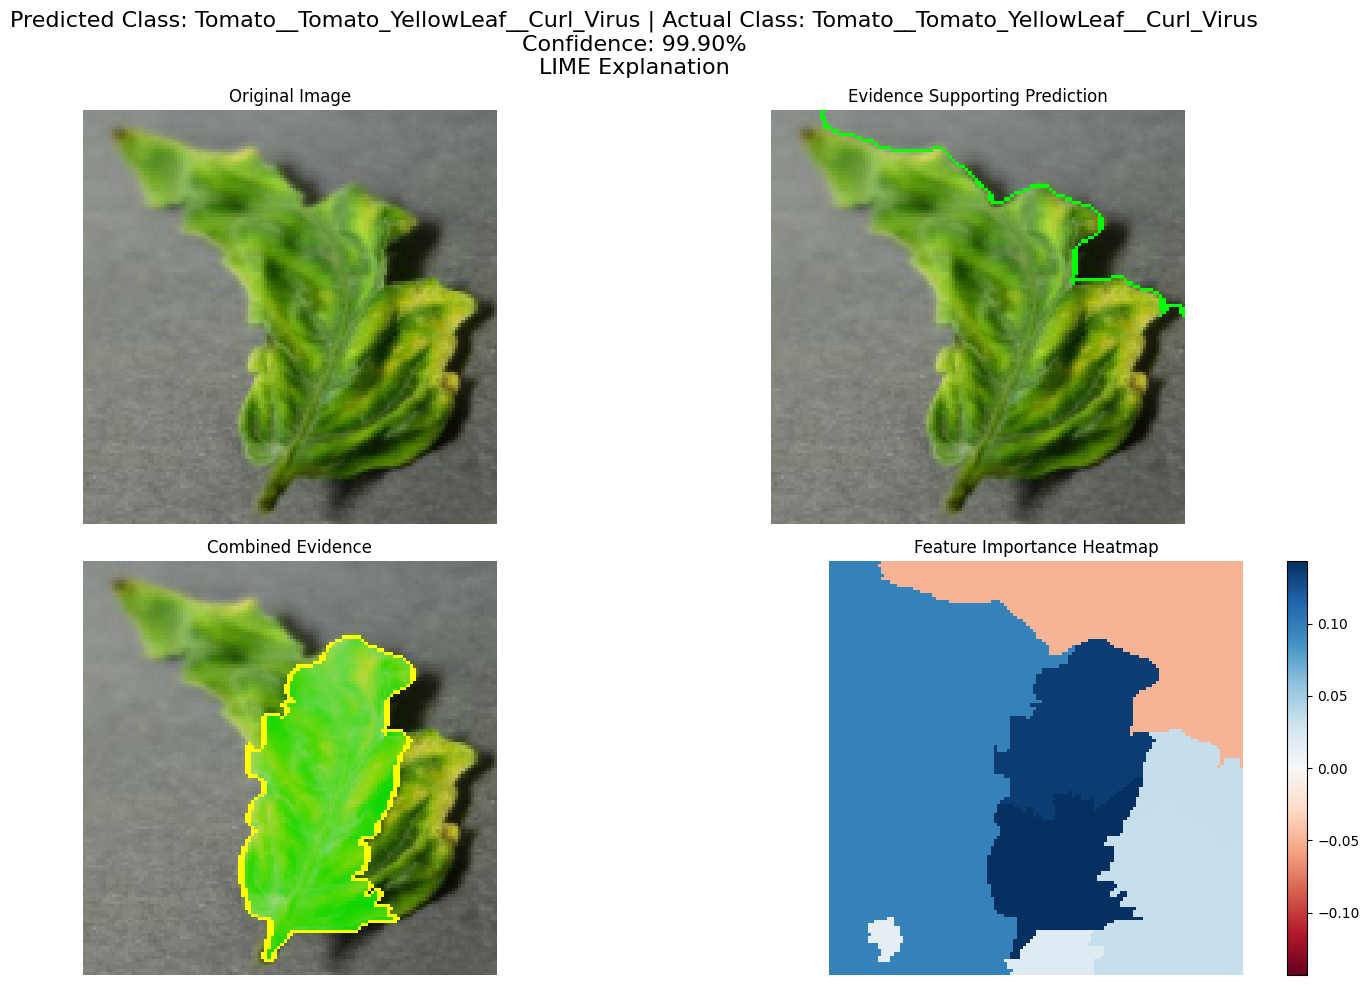


Top 3 Predictions:
Tomato__Tomato_YellowLeaf__Curl_Virus: 99.90%
Tomato_Leaf_Mold: 0.10%
Tomato_Early_blight: 0.00%


In [ ]:
def explain_prediction(image, model, class_names, actual_class, num_samples=2000, num_features=8):
    """Generate and display LIME explanation for an image, including actual class."""
    def predict_fn(images):
        return model.predict(images)

    # Create explainer
    explainer = lime_image.LimeImageExplainer(kernel_width=0.5)

    # Generate explanation
    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=None
    )

    # Get prediction
    pred = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(pred[0])

    # Create visualization
    plt.figure(figsize=(16, 10))

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Positive Evidence (Supporting Prediction)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )
    plt.subplot(2, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask, color=(0, 1, 0)))
    plt.title('Evidence Supporting Prediction')
    plt.axis('off')

    # Combined Evidence
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=num_features,
        hide_rest=False,
        min_weight=0.1
    )
    plt.subplot(2, 2, 3)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('Combined Evidence')
    plt.axis('off')

    # Feature Importance Heatmap
    plt.subplot(2, 2, 4)
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title('Feature Importance Heatmap')
    plt.axis('off')

    # Add prediction and actual class information
    plt.suptitle(
        f"Predicted Class: {class_names[predicted_class]} | Actual Class: {class_names[actual_class]}\n" +
        f"Confidence: {pred[0][predicted_class]:.2%}\n" +
        "LIME Explanation",
        size=16
    )

    plt.tight_layout()
    plt.show()

    # Print top 3 predictions
    top_3_idx = np.argsort(pred[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {pred[0][idx]:.2%}")


# Randomly analyze an image from the test dataset
for images, labels in test_ds.take(1):
    rand_index = np.random.randint(len(images))  # Select a random index from the batch
    image = images[rand_index].numpy().astype('uint8')
    actual_label = labels[rand_index].numpy()
    print(f"\nAnalyzing Image {rand_index + 1}")
    print("=" * 50)
    print(f"Actual Class: {class_names[actual_label]}")
    explain_prediction(image, model, class_names, actual_class=actual_label)



Analyzing Image 10
Actual Class: Pepper__bell___healthy


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

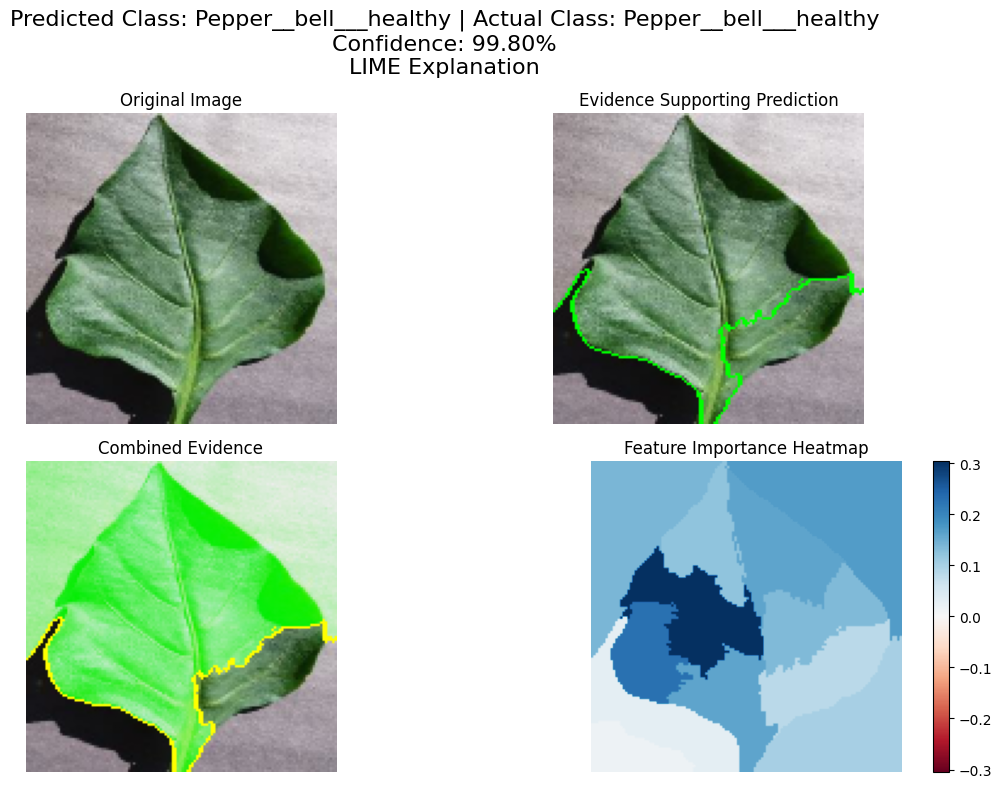


Top 3 Predictions:
Pepper__bell___healthy: 99.80%
Pepper__bell___Bacterial_spot: 0.20%
Tomato__Target_Spot: 0.00%


In [ ]:
def explain_prediction(image, model, class_names, actual_class, num_samples=2000, num_features=8):
    """Generate and display LIME explanation for an image, including actual class."""
    def predict_fn(images):
        return model.predict(images)

    # Create explainer
    explainer = lime_image.LimeImageExplainer(kernel_width=0.5)

    # Generate explanation
    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=None
    )

    # Get prediction
    pred = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(pred[0])

    # Create visualization
    plt.figure(figsize=(12, 8))  # Reduced figure size

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Positive Evidence (Supporting Prediction)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )
    plt.subplot(2, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask, color=(0, 1, 0)))
    plt.title('Evidence Supporting Prediction')
    plt.axis('off')

    # Combined Evidence
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=num_features,
        hide_rest=False,
        min_weight=0.1
    )
    plt.subplot(2, 2, 3)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('Combined Evidence')
    plt.axis('off')

    # Feature Importance Heatmap
    plt.subplot(2, 2, 4)
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title('Feature Importance Heatmap')
    plt.axis('off')

    # Add prediction and actual class information
    plt.suptitle(
        f"Predicted Class: {class_names[predicted_class]} | Actual Class: {class_names[actual_class]}\n" +
        f"Confidence: {pred[0][predicted_class]:.2%}\n" +
        "LIME Explanation",
        size=16
    )

    plt.tight_layout()
    plt.show()

    # Print top 3 predictions
    top_3_idx = np.argsort(pred[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {pred[0][idx]:.2%}")


# Randomly analyze an image from the test dataset
for images, labels in test_ds.take(1):
    rand_index = np.random.randint(len(images))  # Select a random index from the batch
    image = images[rand_index].numpy().astype('uint8')
    actual_label = labels[rand_index].numpy()
    print(f"\nAnalyzing Image {rand_index + 1}")
    print("=" * 50)
    print(f"Actual Class: {class_names[actual_label]}")
    explain_prediction(image, model, class_names, actual_class=actual_label)



Analyzing Image 6
Actual Class: Tomato_healthy


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

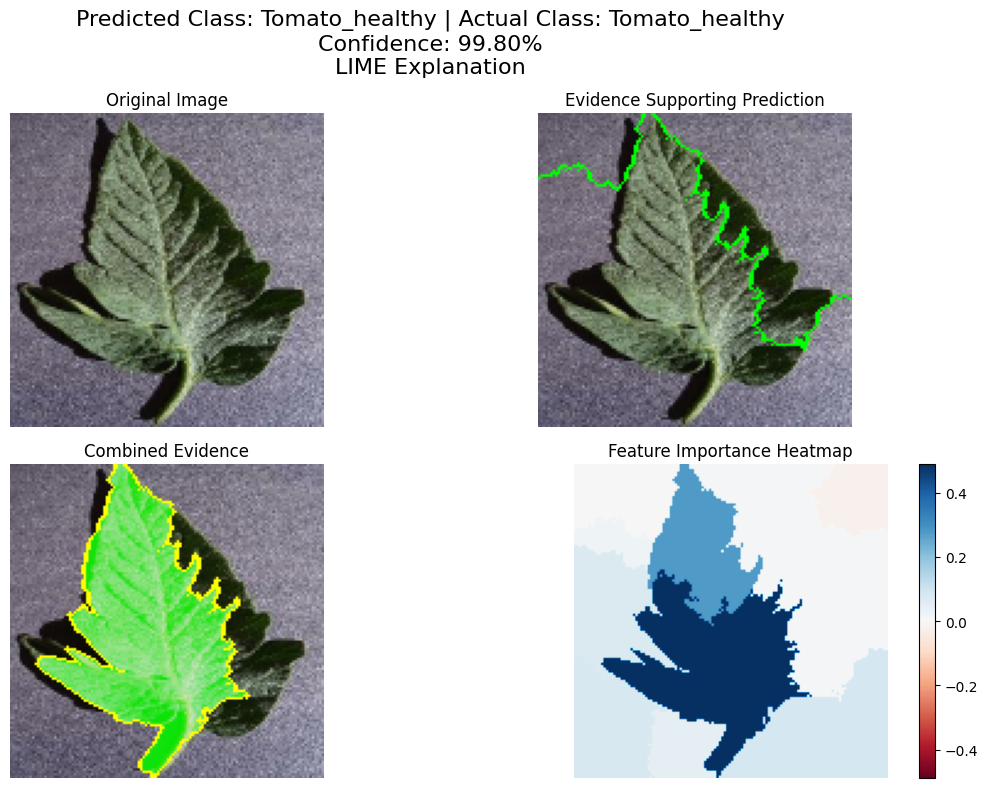


Top 3 Predictions:
Tomato_healthy: 99.80%
Tomato__Target_Spot: 0.11%
Tomato_Spider_mites_Two_spotted_spider_mite: 0.09%


In [ ]:
def explain_prediction(image, model, class_names, actual_class, num_samples=2000, num_features=8):
    """Generate and display LIME explanation for an image, including actual class."""
    def predict_fn(images):
        return model.predict(images)

    # Create explainer
    explainer = lime_image.LimeImageExplainer(kernel_width=0.5)

    # Generate explanation
    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=None
    )

    # Get prediction
    pred = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(pred[0])

    # Create visualization
    plt.figure(figsize=(12, 8))  # Reduced figure size

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Positive Evidence (Supporting Prediction)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )
    plt.subplot(2, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask, color=(0, 1, 0)))
    plt.title('Evidence Supporting Prediction')
    plt.axis('off')

    # Combined Evidence
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=num_features,
        hide_rest=False,
        min_weight=0.1
    )
    plt.subplot(2, 2, 3)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('Combined Evidence')
    plt.axis('off')

    # Feature Importance Heatmap
    plt.subplot(2, 2, 4)
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title('Feature Importance Heatmap')
    plt.axis('off')

    # Add prediction and actual class information
    plt.suptitle(
        f"Predicted Class: {class_names[predicted_class]} | Actual Class: {class_names[actual_class]}\n" +
        f"Confidence: {pred[0][predicted_class]:.2%}\n" +
        "LIME Explanation",
        size=16
    )

    plt.tight_layout()
    plt.show()

    # Print top 3 predictions
    top_3_idx = np.argsort(pred[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {pred[0][idx]:.2%}")


# Randomly analyze an image from the test dataset
for images, labels in test_ds.take(1):
    rand_index = np.random.randint(len(images))  # Select a random index from the batch
    image = images[rand_index].numpy().astype('uint8')
    actual_label = labels[rand_index].numpy()
    print(f"\nAnalyzing Image {rand_index + 1}")
    print("=" * 50)
    print(f"Actual Class: {class_names[actual_label]}")
    explain_prediction(image, model, class_names, actual_class=actual_label)
